Upper level:
$$
\min_c f (c, w ,b ,\xi) = \mathcal{L}_{\mathcal{D}_{val}}(w^*,b^*)=\sum_{i=1}^{ |\mathcal{D_val} | }\tanh\left( 
1-l_i (z^\top w^*+b^*) %\frac{}{\| w^*\|}
\right)
$$

Lower Level objective. $\epsilon$ is set as a very small number in consistent with GAM setting to satisfy Lower Level Strongly Convexisty
$$
w^* ,b^* ,\xi^* = \arg\min_{w ,b ,\xi} g(w,b,\xi,c)=\frac{1}{2}\|w\|^2+\frac{1}{2} \frac{1}{\sum_{i} e^{c_i}}\sum_{i=1}^{ |\mathcal{D_tr} | } e^{c_i}  \xi_i^2
$$
$$
\text{s.t. }~ l_i(z^\top w +b) \geq 1 - \xi_i
$$


# LV-HBA (Commented by Liuyuan)

https://github.com/SUSTech-Optimization/LV-HBA/tree/main/Hyperparameter%20optimization/Linear%20SVM/diabetes

========run seed: 1=========
val acc: 0.38 val loss: 0.32 test acc: 0.37 test loss: 0.34 round: 0
val acc: 0.73 val loss: 0.07 test acc: 0.76 test loss: 0.07 round: 20
val acc: 0.74 val loss: 0.10 test acc: 0.75 test loss: 0.09 round: 40
val acc: 0.75 val loss: 0.11 test acc: 0.76 test loss: 0.10 round: 60
========run seed: 2=========
val acc: 0.38 val loss: 0.32 test acc: 0.26 test loss: 0.42 round: 0
val acc: 0.76 val loss: 0.07 test acc: 0.80 test loss: 0.06 round: 20
val acc: 0.76 val loss: 0.08 test acc: 0.80 test loss: 0.06 round: 40
val acc: 0.76 val loss: 0.08 test acc: 0.79 test loss: 0.06 round: 60
========run seed: 3=========
val acc: 0.36 val loss: 0.34 test acc: 0.42 test loss: 0.30 round: 0
val acc: 0.75 val loss: 0.07 test acc: 0.75 test loss: 0.09 round: 20
val acc: 0.74 val loss: 0.08 test acc: 0.74 test loss: 0.08 round: 40
val acc: 0.75 val loss: 0.09 test acc: 0.75 test loss: 0.08 round: 60
========run seed: 4=========
val acc: 0.40 val loss: 0.32 test acc: 0.39 tes

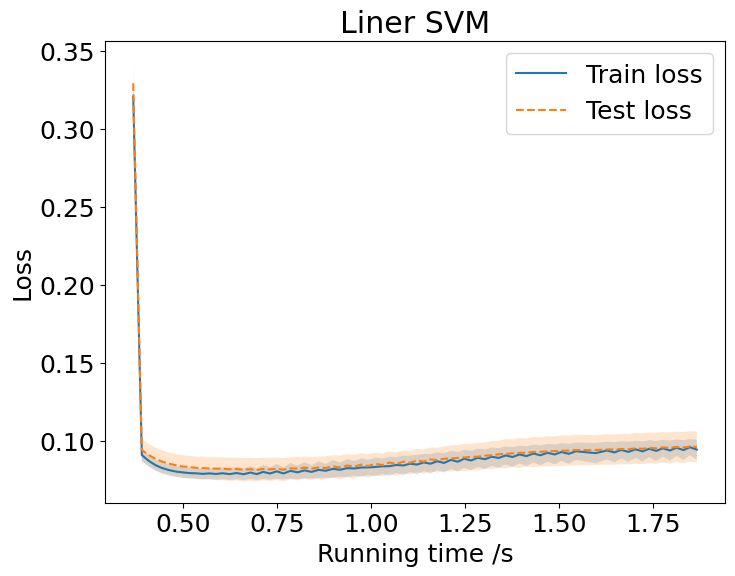

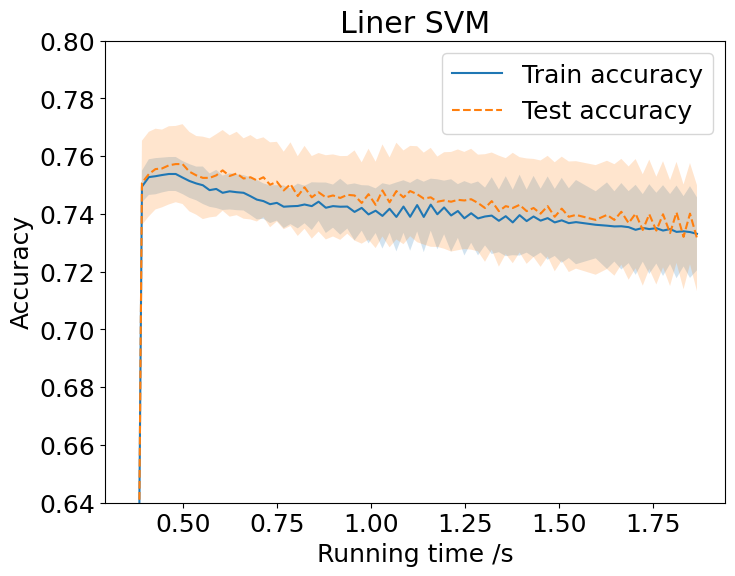

time 76.43873286247253


In [1]:
import cvxpy as cp
import numpy as np
import time
import torch
import copy
from torch import nn 
from torch.utils.data import Dataset,DataLoader,TensorDataset
from torch.nn import functional as F

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sys, random, time
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


class LinearSVM(nn.Module):
    def __init__(self, input_size, n_classes, n_sample):
        super(LinearSVM, self).__init__()
        self.w = nn.Parameter(torch.ones(n_classes, input_size))
        self.b = nn.Parameter(torch.tensor(0.))
        self.xi = nn.Parameter(torch.ones(n_sample))
        self.C = nn.Parameter(torch.ones(n_sample))
    
    def forward(self, x):
        return F.linear(x, self.w, self.b)

    def loss_upper(self, y_pred, y_val):
        y_val_tensor = torch.Tensor(y_val)
        x = torch.reshape(y_val_tensor, (y_val_tensor.shape[0],1)) * y_pred / torch.linalg.norm(self.w)
        relu = nn.LeakyReLU()
        loss = torch.sum(relu(2*torch.sigmoid(-5.0*x)-1.0))
        return loss

    def loss_lower(self):
        w2 = 0.5*torch.linalg.norm(self.w)**2
        c_exp=torch.exp(self.C)
        xi_term = 0.5 * (torch.dot(c_exp, (self.xi)**2))
        loss =  w2 + xi_term
        return loss

    def constrain_values(self, srt_id, y_pred, y_train):
        xi_sidx = srt_id
        xi_eidx = srt_id+len(y_pred)
        xi_batch = self.xi[xi_sidx:xi_eidx]
        return 1-xi_batch-y_train.view(-1)*y_pred.view(-1)

def run(seed, epochs):
    print("========run seed: {}=========".format(seed))

    ############ Load data code ###########
    data_list=[]

    f = open("diabete.txt",encoding = "utf-8")
    a_list=f.readlines()
    f.close()
    for line in a_list:
        line1=line.replace('\n', '')
        line2=list(line1.split(' '))
        y=float(line2[0])
        x= [float(line2[i].split(':')[1]) for i in (1,2,3,4,5,6,7,8)]
        data_list.append(x+[y])

    data_array=np.array(data_list)
    np.random.seed(seed)
    np.random.shuffle(data_array)

    z_train=data_array[:500, :-1]
    y_train=data_array[:500, -1]
    z_val=data_array[500:650, :-1]
    y_val=data_array[500:650, -1]
    z_test=data_array[650:, :-1]
    y_test=data_array[650:, -1]

    batch_size = 256
    data_train = TensorDataset(
        torch.tensor(z_train, dtype=torch.float32), 
        torch.tensor(y_train, dtype=torch.float32))
    train_loader = DataLoader(
        dataset=data_train,
        batch_size=batch_size,
        shuffle=True)
    data_val = TensorDataset(
        torch.tensor(z_val, dtype=torch.float32), 
        torch.tensor(y_val, dtype=torch.float32))
    val_loader = DataLoader(
        dataset=data_val,
        batch_size=batch_size,
        shuffle=True)
    data_test = TensorDataset(
        torch.tensor(z_test, dtype=torch.float32), 
        torch.tensor(y_test, dtype=torch.float32))
    test_loader = DataLoader(
        dataset=data_test,
        batch_size=batch_size,
        shuffle=True)

    #print(y_train.shape)
    #print(y_val.shape)
    #print(y_test.shape)
    #print(c_array_tensor.shape)
    ############ End Load data code ###########
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    
    

    ############ Setting SVM ###########
    feature = 8
    N_sample = y_train.shape[0]
    
    model = LinearSVM(feature, 1, N_sample)
    model.C.data.copy_(torch.Tensor(z_train.shape[0]).uniform_(-6.0,-5.0))    ####### Setting C on training data
    model_theta = copy.deepcopy(model)    ####### ?????????????

    ######### SVM variables
    lamda = torch.ones(N_sample) #+ 1./N_sample
    z = torch.ones(N_sample) #+ 1./N_sample

    params = [p for n, p in model.named_parameters() if n != 'C']
    params_theta = [p for n, p in model_theta.named_parameters() if n != 'C']

    

    ############### This is for projection
    x = cp.Variable(feature+1+2*N_sample)
    y = cp.Parameter(feature+1+2*N_sample)
    w = x[0:feature]
    b = x[feature]
    xi = x[feature+1:feature+1+N_sample]
    C = x[feature+1+N_sample:]

    loss = cp.norm(x-y, 2)**2

    constraints=[]
    for i in range(y_train.shape[0]):
        constraints.append(1 - xi[i] - y_train[i] * (cp.scalar_product(w, z_train[i])+b) <= 0)


    obj = cp.Minimize(loss)
    prob = cp.Problem(obj, constraints)
    ############### The above is for projection

    ######################
    val_loss_list=[]
    test_loss_list=[]
    val_acc_list=[]
    test_acc_list=[]
    time_computation=[]

    ############ LV-HBA parameter ###########   
    alpha = 0.01
    beta = 0.1
    yita = 0.001 
    gama1 = 0.1
    gama2 = 0.1
    #ck = 0.1
    u = 200

    alpha = 0.01
    beta = 0.1
    beta = 0.01 
    gama1 = 0.1
    gama2 = 0.1
    #ck = 0.1
    
    #epochs = 80
    algorithm_start_time=time.time()
    
    ############ LV-HBA algorithm ###########    
    for k in range(epochs):
        ck = 1/((k+1)**0.5)


        ################## Lower Level
        model_theta.zero_grad()
        loss = model_theta.loss_lower()
        loss.backward()

        ############### go through training to build up idx_glob constr_glob_list
        idx_glob = 0
        constr_glob_list = torch.ones(0)
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            log_probs = model_theta(images)
            cv = model_theta.constrain_values(idx_glob, log_probs, labels)
            lamda_batch = lamda[idx_glob:idx_glob+len(labels)]
            cv.backward(lamda_batch)
            constr_glob_list = torch.cat((constr_glob_list, cv), 0)
            idx_glob += len(labels)

        # ############ This is the algorithm
        for i, p_theta in enumerate(params_theta):
            d4_theta = torch.zeros_like(p_theta.data)
            if p_theta.grad is not None:
                d4_theta += p_theta.grad
            d4_theta += gama1*(p_theta.data - params[i].data)
            p_theta.data.add_(d4_theta, alpha=-yita)

        lamda = lamda - yita*(-constr_glob_list + gama2*(lamda - z))

        ############## go through training again to build up idx_glob in another order
        model_theta.zero_grad()
        loss = model_theta.loss_lower()
        loss.backward()

        idx_glob = 0
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            log_probs = model_theta(images)
            cv = model_theta.constrain_values(idx_glob, log_probs, labels)
            lamda_batch = lamda[idx_glob:idx_glob+len(labels)]
            cv.backward(lamda_batch)
            idx_glob += len(labels)


        # ############## upper using model on validation data
        model.zero_grad()
        loss = model.loss_lower() #loss_upper
        loss.backward()

        ################ Upper lever: validation data
        for batch_idx, (images, labels) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)
            log_probs = model(images)
            loss = model.loss_upper(log_probs, labels)
            loss.backward(torch.tensor(ck))
        

        for i, p in enumerate(params):
            d2 = torch.zeros_like(p.data)
            if p.grad is not None:
                d2 += p.grad
            d2 += gama1*(params_theta[i].data - p.data)
            p.data.add_(d2, alpha=-alpha)

        d1 = model.C.grad - model_theta.C.grad
        model.C.data.add(d1, alpha=-alpha)

        
        #prob.solve(solver='MOSEK', warm_start=True, verbose=True)
        y_w = model.w.data.view(-1).detach().numpy()
        y_b = model.b.data.detach()
        y_xi = model.xi.data.view(-1).detach().numpy()
        y_C = model.C.data.view(-1).detach().numpy()

        y.value = np.concatenate((y_w, np.array([y_b]), y_xi, y_C))

        #### ?????????? projection
        prob.solve(solver='ECOS', abstol=2e-3,reltol=2e-3,max_iters=1000000000, warm_start=True)  
        C_solv = torch.Tensor(np.array(C.value))
        w_solv = torch.Tensor(np.array([w.value]))
        b_solv = torch.tensor(b.value)
        xi_solv = torch.Tensor(np.array(xi.value))

        model_theta.C.data.copy_(C_solv)
        model.C.data.copy_(C_solv)
        model.w.data.copy_(w_solv)
        model.b.data.copy_(b_solv)
        model.xi.data.copy_(xi_solv)


        number_right = 0
        val_loss = 0
        for batch_idx, (images, labels) in enumerate(train_loader): #val_loader
            images, labels = images.to(device), labels.to(device)
            log_probs = model(images)
            for i in range(len(labels)):
                q=log_probs[i]*labels[i]
                if q>0:
                    number_right=number_right+1
            val_loss += model.loss_upper(log_probs, labels)
        val_acc=number_right/len(y_train)
        val_loss /= len(y_train)     #############????????????

        number_right=0
        test_loss = 0
        for batch_idx, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            log_probs = model(images)
            for i in range(len(labels)):
                q=log_probs[i]*labels[i]
                if q>0:
                    number_right=number_right+1
            test_loss += model.loss_upper(log_probs, labels)
        test_acc =number_right/len(y_test)
        test_loss /= len(y_test)  #############????????????
        if k%20==0:
            print("val acc: {:.2f}".format(val_acc),
              "val loss: {:.2f}".format(val_loss),
              "test acc: {:.2f}".format(test_acc),
              "test loss: {:.2f}".format(test_loss),
              "round: {}".format(k))

        val_loss_list.append(val_loss.detach().numpy())
        test_loss_list.append(test_loss.detach().numpy())
        val_acc_list.append(val_acc)
        test_acc_list.append(test_acc)
        time_computation.append(time.time()-algorithm_start_time)

    end_time = time.time()
    time_duaration = end_time - algorithm_start_time

    return val_loss_list,test_loss_list,val_acc_list,test_acc_list,time_computation,time_duaration



if __name__ == "__main__":
    # if len(sys.argv) == 3:
    #     print(sys.argv[1])
    #     data_loop = int(sys.argv[1])
    #     epochs = int(sys.argv[2])
    # else:
    #     print("Invalid params, run with default setting")
    #     data_loop = 40
    #     epochs = 80
    data_loop = 40
    epochs = 80
    
    start_time = time.time()
    val_loss_array=[]
    test_loss_array=[]
    val_acc_array=[]
    test_acc_array=[]
    time_duaration_array=[]
    for seed in range(1,data_loop):
        val_loss_list,test_loss_list,val_acc_list,test_acc_list,time_computation, time_duaration=run(seed, epochs)
        val_loss_array.append(np.array(val_loss_list))
        test_loss_array.append(np.array(test_loss_list))
        val_acc_array.append(np.array(val_acc_list))
        test_acc_array.append(np.array(test_acc_list))
        time_computation=np.array(time_computation)
        time_duaration_array.append(time_duaration)
    val_loss_array=np.array(val_loss_array)
    test_loss_array=np.array(test_loss_array)
    val_acc_array=np.array(val_acc_array)
    test_acc_array=np.array(test_acc_array)
    time_duaration_array=np.array(time_duaration_array)

    val_loss_mean=np.sum(val_loss_array,axis=0)/val_loss_array.shape[0]
    val_loss_sd=np.sqrt(np.var(val_loss_array,axis=0))/2.0
    test_loss_mean=np.sum(test_loss_array,axis=0)/test_loss_array.shape[0]
    test_loss_sd=np.sqrt(np.var(test_loss_array,axis=0))/2.0

    val_acc_mean=np.sum(val_acc_array,axis=0)/val_acc_array.shape[0]
    val_acc_sd=np.sqrt(np.var(val_acc_array,axis=0))/2.0
    test_acc_mean=np.sum(test_acc_array,axis=0)/test_acc_array.shape[0]
    test_acc_sd=np.sqrt(np.var(test_acc_array,axis=0))/2.0

    time_mean=np.sum(time_duaration_array,axis=0)/time_duaration_array.shape[0]
    print("*******************")
    print("Average runing time for my algorithm: ", time_mean)
    print("Average test loss: ", test_loss_mean[-1])
    print("Average test acc: ", test_acc_mean[-1])
    print("*******************")

    plt.rcParams.update({'font.size': 18})
    #plt.rcParams['font.sans-serif']=['Arial']
    plt.rcParams['axes.unicode_minus']=False 
    #axis=np.arange(1, 81)
    axis=time_computation
    plt.figure(figsize=(8,6))
    #plt.grid(linestyle = "--") 
    ax = plt.gca()
    plt.plot(axis,val_loss_mean,'-',label="Train loss")
    ax.fill_between(axis,val_loss_mean-val_loss_sd,val_loss_mean+val_loss_sd,alpha=0.2)
    plt.plot(axis,test_loss_mean,'--',label="Test loss")
    ax.fill_between(axis,test_loss_mean-test_loss_sd,test_loss_mean+test_loss_sd,alpha=0.2)
    #plt.xticks(np.arange(0,iterations,40))
    plt.title('Liner SVM')
    plt.xlabel('Running time /s')
    #plt.legend(loc=4)
    plt.ylabel("Loss")
    #plt.xlim(-0.5,3.5)
    #plt.ylim(0.5,1.0)
    plt.legend(loc=0, numpoints=1)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    #plt.setp(ltext, fontsize=18,fontweight='bold')
    plt.savefig('new_run_diabete_1.pdf') 
    plt.show()

    #axis=np.arange(1, 81)
    axis=time_computation
    plt.figure(figsize=(8,6))
    ax = plt.gca()
    plt.plot(axis,val_acc_mean,'-',label="Train accuracy")
    ax.fill_between(axis,val_acc_mean-val_acc_sd,val_acc_mean+val_acc_sd,alpha=0.2)
    plt.plot(axis,test_acc_mean,'--',label="Test accuracy")
    ax.fill_between(axis,test_acc_mean-test_acc_sd,test_acc_mean+test_acc_sd,alpha=0.2) 
    #plt.xticks(np.arange(0,iterations,40))
    plt.title('Liner SVM')
    plt.xlabel('Running time /s')
    plt.ylabel("Accuracy")
    plt.ylim(0.64,0.8)
    #plt.legend(loc=4)
    plt.legend(loc=0, numpoints=1)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    #plt.setp(ltext, fontsize=18,fontweight='bold') 
    plt.savefig('new_run_diabete_2.pdf') 
    plt.show()

    end_time = time.time()
    print("time", end_time - start_time)



# GAM
https://github.com/xsy786912649/Efficient-gradient-approximation-method-for-constrained-bilevel-optimization-problem/tree/main/HO_SVM

(500,)
(150,)
(118,)
torch.Size([500])
0.6533333333333333
0.7033898305084746
0
500
value: 0.3211402115311787
upper_loss:  2.952378336588542
test_loss_upper:  2.6131111080363643
0.6466666666666666
0.7033898305084746
0
500
value: 0.3236989688506097
upper_loss:  2.788763173421224
test_loss_upper:  2.4957967208603677
0.68
0.711864406779661
0
500
value: 0.32654315806258
upper_loss:  2.6051478068033855
test_loss_upper:  2.343944937495862
0.6866666666666666
0.7033898305084746
0
500
value: 0.3282686905627362
upper_loss:  2.532762145996094
test_loss_upper:  2.2461685891878806
0.6933333333333334
0.6949152542372882
0
500
value: 0.329651785530182
upper_loss:  2.481316630045573
test_loss_upper:  2.1708344605009433
0.7
0.711864406779661
0
500
value: 0.3310558311566054
upper_loss:  2.436309305826823
test_loss_upper:  2.1040219775700972
0.7066666666666667
0.7203389830508474
0
500
value: 0.33244961856345956
upper_loss:  2.3850629170735678
test_loss_upper:  2.0371191380387645
0.7266666666666667
0.720338

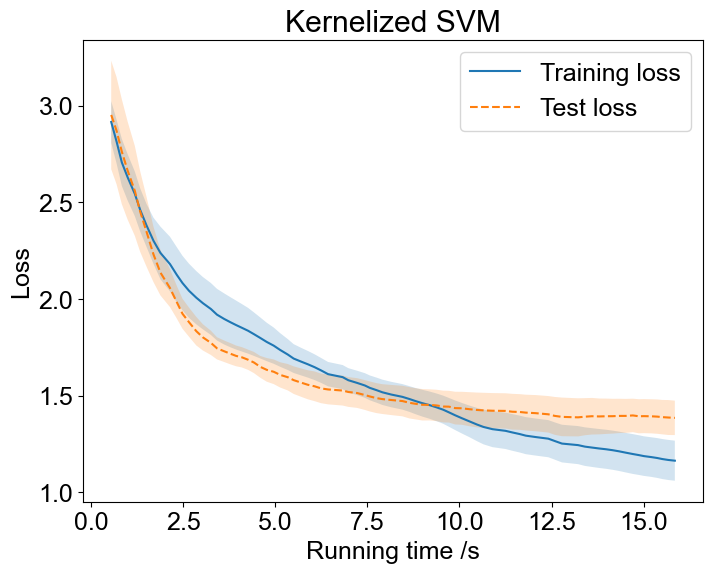

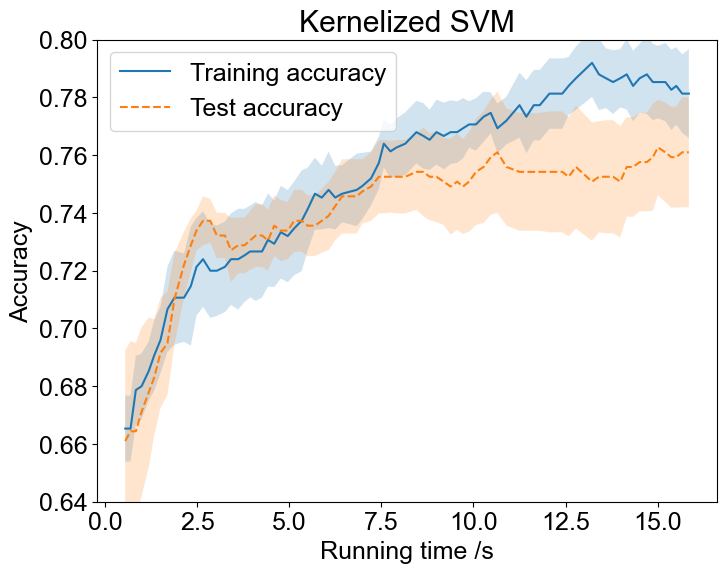

In [233]:
import cvxpy as cp
import numpy as np
import time
import torch
from torch import nn 
from torch.utils.data import Dataset,DataLoader,TensorDataset
from torch.nn import functional as F

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sys, random, time
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# dataset = diabete
# feature = 8
# number = 768

def run(seed, epoch = 80):
    data_list=[]

    f = open("diabete.txt",encoding = "utf-8")
    a_list=f.readlines()
    f.close()
    for line in a_list:
        line1=line.replace('\n', '')
        line2=list(line1.split(' '))
        y=float(line2[0])
        x= [float(line2[i].split(':')[1]) for i in (1,2,3,4,5,6,7,8)]
        data_list.append(x+[y])

    data_array_1=np.array(data_list)[:,:-1]
    data_array_0=np.ones((data_array_1.shape[0],1))
    data_array_2=data_array_1*data_array_1
    data_array_3=np.empty((data_array_1.shape[0],0))

    for i in range(data_array_1.shape[1]):
        for j in range(data_array_1.shape[1]):
            if i<j:
                data_array_i=data_array_1[:,i]*data_array_1[:,j]
                data_array_i=np.reshape(data_array_i,(-1,1))
                data_array_3=np.hstack((data_array_3,data_array_i))

    data_array_4=np.reshape(np.array(data_list)[:,-1],(-1,1))

    data_array=np.hstack((data_array_0,data_array_1,data_array_2,data_array_3,data_array_4))

    np.random.seed(seed)
    np.random.shuffle(data_array)

    z_train=data_array[:500, :-1]
    y_train=data_array[:500, -1]
    z_val=data_array[500:650, :-1]
    y_val=data_array[500:650, -1]
    z_test=data_array[650:, :-1]
    y_test=data_array[650:, -1]

    c_array= torch.Tensor(z_train.shape[0]).uniform_(-7.0,-6.0)
    #c_array= torch.Tensor(z_train.shape[0]).uniform_(1.0,2.0)
    c_array_tensor=torch.exp(c_array)

    print(y_train.shape)
    print(y_val.shape)
    print(y_test.shape)
    print(c_array_tensor.shape)

    feature=z_train.shape[1]

    w = cp.Variable(feature)
    b = cp.Variable()
    xi = cp.Variable(y_train.shape[0])
    C = cp.Parameter(y_train.shape[0],nonneg=True)
    loss =  0.5*cp.norm(w, 2)**2 + 0.5 * (cp.scalar_product(C, cp.power(xi,2)))

    # Create two constraints.
    constraints=[]
    constraints_value=[]
    for i in range(y_train.shape[0]):
        constraints.append(1 - xi[i] - y_train[i] * (cp.scalar_product(w, z_train[i])+b) <= 0)
        constraints_value.append(1 - xi[i] - y_train[i] * (cp.scalar_product(w, z_train[i])+b) )

    # Form objective.
    obj = cp.Minimize(loss)

    # Form and solve problem.
    prob = cp.Problem(obj, constraints)

    val_loss_list=[]
    test_loss_list=[]
    val_acc_list=[]
    test_acc_list=[]
    time_computation=[]
    algorithm_start_time=time.time()

    for j in range( epoch ):
        epsilon=0.005
        C.value=c_array_tensor.detach().numpy()

        begin=time.time()
        prob.solve(solver='ECOS', abstol=2e-3,reltol=2e-3,max_iters=1000000000, warm_start=True)  
        end=time.time()
        # print("time: ",end-begin)

        dual_variables= np.array([ constraints[i].dual_value for i in range(len(constraints))])
        constraints_value_1= np.array([ constraints_value[i].value for i in range(len(constraints))])
        #print("dual variables", dual_variables)
        #print("constraints_value ", constraints_value_1)
        #print("w value:", (w.value))
        #print("b value:", (b.value))
        #print("xi value:", (xi.value))

        ######### Accuracy
        number_right=0
        for i in range(len(y_val)):
            q=y_val[i] * (cp.scalar_product(w, z_val[i])+b)
            if q.value>0:
                number_right=number_right+1
        val_acc=number_right/len(y_val)
        print(val_acc)

        number_right=0
        for i in range(len(y_test)):
            q=y_test[i] * (cp.scalar_product(w, z_test[i])+b)
            if q.value>0:
                number_right=number_right+1
        test_acc=number_right/len(y_test)
        print(test_acc)

        w_tensor=torch.Tensor(np.array([w.value])).requires_grad_()
        b_tensor=torch.Tensor(np.array([b.value])).requires_grad_()

        x = torch.reshape(torch.Tensor(y_val), (torch.Tensor(y_val).shape[0],1)) * F.linear(torch.Tensor(z_val), w_tensor, b_tensor) / torch.linalg.norm(w_tensor)
        relu = nn.LeakyReLU()
        loss_upper= torch.sum(relu(2*torch.sigmoid(-5.0*x)-1.0))
        x1 = torch.reshape(torch.Tensor(y_test), (torch.Tensor(y_test).shape[0],1)) * F.linear(torch.Tensor(z_test), w_tensor, b_tensor) / torch.linalg.norm(w_tensor)
        test_loss_upper= torch.sum(relu(2*torch.sigmoid(-5.0*x1)-1.0)) 

        inactive_constraint_list=[]
        for i in range(len(y_train)):
            if constraints_value_1[i]<-0.00001:
                inactive_constraint_list.append(i)
        print(len(inactive_constraint_list))

        active_constraint_list=[]
        for i in range(len(y_train)):
            if dual_variables[i]>0.00001:
                active_constraint_list.append(i)
        print(len(active_constraint_list))

        print("value:",(obj.value))

        #M = np.zeros((feature+1+y_train.shape[0]+len(active_constraint_list),feature+1+y_train.shape[0]+len(active_constraint_list)), dtype = float) 


        v1=np.ones((feature,))
        v2=np.zeros((1,))
        v3=c_array_tensor.detach().numpy()
        M1= np.diag(np.hstack((v1,v2,v3)))
        M2 = np.empty([0,0], dtype = float) 
        #v4= np.zeros((1, feature+1+y_train.shape[0]+len(active_constraint_list) ), dtype = float) 
        M2_list=[]
        for i in range(y_train.shape[0]):
            if i in active_constraint_list:
                M2_list.append( np.array([ np.hstack((z_train[i]* (-y_train[i]),np.array([-y_train[i]]),-np.eye(y_train.shape[0])[i])) ]) )
        M2= np.vstack(M2_list)

        M3= np.transpose(M2)
        M4 = np.zeros((len(active_constraint_list),len(active_constraint_list)))
        M = np.hstack((np.vstack((M1,M2)), np.vstack((M3,M4))))
        #print(M.shape)
        #print(np.linalg.matrix_rank(M))
        
        n1=np.zeros((feature+1, y_train.shape[0]))
        n2=np.diag(np.array(xi.value)*c_array_tensor.detach().numpy())
        n3=np.zeros((len(active_constraint_list),y_train.shape[0]))
        N=np.vstack((n1,n2,n3))
        #print(N.shape)

        d=-np.dot(np.linalg.inv(M), N) 
        d1=d[0:feature+1,]
        d2=d[feature+1:feature+1+y_train.shape[0],]
        d3=d[feature+1+y_train.shape[0]:feature+1+y_train.shape[0]+len(active_constraint_list),]

        alpha=0.05
        print("upper_loss: ", loss_upper.detach().numpy()/15.0)
        print("test_loss_upper: ", test_loss_upper.detach().numpy()/11.8)
        loss_upper.backward()
        grads_w = w_tensor.grad.detach().numpy()[0]
        grads_b = b_tensor.grad.detach().numpy()
        grad=np.hstack((grads_w,grads_b))
        grad=np.reshape(grad,(1,grad.shape[0]))
        grad_update=np.dot(grad,d1)[0]
        c_array=c_array-alpha*grad_update
        c_array_tensor=torch.exp(c_array)

        val_loss_list.append(loss_upper.detach().numpy()/15.0)
        test_loss_list.append(test_loss_upper.detach().numpy()/11.8)
        val_acc_list.append(val_acc)
        test_acc_list.append(test_acc)
        time_computation.append(time.time()-algorithm_start_time)

    return val_loss_list,test_loss_list,val_acc_list,test_acc_list,time_computation


if __name__ == "__main__":
    val_loss_array=[]
    test_loss_array=[]
    val_acc_array=[]
    test_acc_array=[]
    for seed in range(5):
        val_loss_list,test_loss_list,val_acc_list,test_acc_list,time_computation=run(seed)
        val_loss_array.append(np.array(val_loss_list))
        test_loss_array.append(np.array(test_loss_list))
        val_acc_array.append(np.array(val_acc_list))
        test_acc_array.append(np.array(test_acc_list))
        time_computation=np.array(time_computation)
    val_loss_array=np.array(val_loss_array)
    test_loss_array=np.array(test_loss_array)
    val_acc_array=np.array(val_acc_array)
    test_acc_array=np.array(test_acc_array)

    val_loss_mean=np.sum(val_loss_array,axis=0)/val_loss_array.shape[0]
    val_loss_sd=np.sqrt(np.var(val_loss_array,axis=0))/2.0
    test_loss_mean=np.sum(test_loss_array,axis=0)/test_loss_array.shape[0]
    test_loss_sd=np.sqrt(np.var(test_loss_array,axis=0))/2.0

    val_acc_mean=np.sum(val_acc_array,axis=0)/val_acc_array.shape[0]
    val_acc_sd=np.sqrt(np.var(val_acc_array,axis=0))/2.0
    test_acc_mean=np.sum(test_acc_array,axis=0)/test_acc_array.shape[0]
    test_acc_sd=np.sqrt(np.var(test_acc_array,axis=0))/2.0

    plt.rcParams.update({'font.size': 18})
    plt.rcParams['font.sans-serif']=['Arial']#如果要显示中文字体，则在此处设为：SimHei
    plt.rcParams['axes.unicode_minus']=False #显示负号
    axis=time_computation
    plt.figure(figsize=(8,6))
    #plt.grid(linestyle = "--") #设置背景网格线为虚线
    ax = plt.gca()
    plt.plot(axis,val_loss_mean,'-',label="Training loss")
    ax.fill_between(axis,val_loss_mean-val_loss_sd,val_loss_mean+val_loss_sd,alpha=0.2)
    plt.plot(axis,test_loss_mean,'--',label="Test loss")
    ax.fill_between(axis,test_loss_mean-test_loss_sd,test_loss_mean+test_loss_sd,alpha=0.2)
    #plt.xticks(np.arange(0,iterations,40))
    plt.title('Kernelized SVM')
    plt.xlabel('Running time /s')
    #plt.legend(loc=4)
    plt.ylabel("Loss")
    #plt.xlim(-0.5,3.5)
    #plt.ylim(0.5,1.0)
    plt.legend(loc=0, numpoints=1)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    #plt.setp(ltext, fontsize=18,fontweight='bold') #设置图例字体的大小和粗细
    plt.savefig('ho_svm_kernel_1.pdf') 
    #plt.show()

    axis=time_computation
    plt.figure(figsize=(8,6))
    ax = plt.gca()
    plt.plot(axis,val_acc_mean,'-',label="Training accuracy")
    ax.fill_between(axis,val_acc_mean-val_acc_sd,val_acc_mean+val_acc_sd,alpha=0.2)
    plt.plot(axis,test_acc_mean,'--',label="Test accuracy")
    ax.fill_between(axis,test_acc_mean-test_acc_sd,test_acc_mean+test_acc_sd,alpha=0.2) 
    #plt.xticks(np.arange(0,iterations,40))
    plt.title('Kernelized SVM')
    plt.xlabel('Running time /s')
    plt.ylabel("Accuracy")
    plt.ylim(0.64,0.8)
    #plt.legend(loc=4)
    plt.legend(loc=0, numpoints=1)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    #plt.setp(ltext, fontsize=18,fontweight='bold') #设置图例字体的大小和粗细
    plt.savefig('ho_svm_kernel_2.pdf') 
    plt.show()

# Ours

Upper level:
$$
\min_c f (c, w ,b ,\xi) = \mathcal{L}_{\mathcal{D}_{val}}(w^*,b^*)=\sum_{i=1}^{ |\mathcal{D_val} | }\exp\left( 
1-l_i (z^\top w^*+b^*) %\frac{}{\| w^*\|}
\right)
$$

**Upper Level is set like this due to form a solvable upper level problem for cp package.**

Lower Level objective. $\epsilon$ is set as a very small number in consistent with GAM setting to satisfy Lower Level Strongly Convexisty
$$
w^* ,b^* ,\xi^* = \arg\min_{w ,b ,\xi} g(w,b,\xi,c)=\frac{1}{2}\|w\|^2+\frac{1}{2} \frac{1}{\sum_{i} e^{c_i}}\sum_{i=1}^{ |\mathcal{D_tr} | } e^{c_i}  \xi_i^2
$$
$$
\text{s.t. }~ l_i(z^\top w +b) \geq 1 - \xi_i
$$

**Hyper parameter choice**

- `gam`: 5
- `C`: randomly generated following Uniform(-5,5)

In [170]:
import cvxpy as cp
import numpy as np
import time
import torch
import copy
from torch import nn 
from torch.utils.data import Dataset,DataLoader,TensorDataset
from torch.nn import functional as F

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sys, random, time
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [236]:
def run_ours(seed, epoch = 80, gam = 5):
    print(f" ************** seed {seed} ************** ")
    ################## Load Data
    data_list=[]
    f = open("diabete.txt",encoding = "utf-8")
    a_list=f.readlines()
    f.close()
    for line in a_list:
        line1=line.replace('\n', '')
        line2=list(line1.split(' '))
        y=float(line2[0])
        x= [float(line2[i].split(':')[1]) for i in (1,2,3,4,5,6,7,8)]
        data_list.append(x+[y])

    data_array_1=np.array(data_list)[:,:-1]
    data_array_0=np.ones((data_array_1.shape[0],1))
    data_array_2=data_array_1*data_array_1
    data_array_3=np.empty((data_array_1.shape[0],0))

    for i in range(data_array_1.shape[1]):
        for j in range(data_array_1.shape[1]):
            if i<j:
                data_array_i=data_array_1[:,i]*data_array_1[:,j]
                data_array_i=np.reshape(data_array_i,(-1,1))
                data_array_3=np.hstack((data_array_3,data_array_i))

    data_array_4=np.reshape(np.array(data_list)[:,-1],(-1,1))
    data_array=np.hstack((data_array_0,data_array_1,data_array_2,data_array_3,data_array_4))

    np.random.seed(seed)
    np.random.shuffle(data_array)

    ########## Z is the training data Y is the label
    z_train=data_array[:500, :-1]
    y_train=data_array[:500, -1]
    z_val=data_array[500:650, :-1]
    y_val=data_array[500:650, -1]
    z_test=data_array[650:, :-1]
    y_test=data_array[650:, -1]

    feature=z_train.shape[1] # = 8
    ######### parameters
    c_array= torch.Tensor(z_train.shape[0]).uniform_(-3,3)
    c_array_tensor = torch.exp(c_array) 

    C = cp.Parameter(y_train.shape[0], nonneg=True)
    
    # Parameters for eq. (12)
    w = cp.Variable(feature)
    b = cp.Variable()
    xi = cp.Variable(y_train.shape[0])
    

    # Parameters for eq. (13)
    w_F = cp.Variable(feature)
    b_F = cp.Variable()
    xi_F = cp.Variable(y_train.shape[0])

    ######### 2 level objectives
    loss_lower =  0.5*cp.norm(w, 2)**2 + 0.5 * (cp.scalar_product(C, cp.power(xi,2))) # cp.exp(C)
    
    
    # Compute the linear combination
    # loss_upper =  cp.sum(1/(1+cp.exp(-(y_val.reshape(len(y_val), 1)*z_val@w_F + b_F)/cp.norm(w_F, 2)**2)))
    #### For reformulation 
    #linear_combination = y_val.reshape(len(y_val), 1) * z_val @ w_F + b_F
    
    # Compute the sum of sigmoid activations using the log-sum-exp function
    #log_sum_exp_term = cp.log_sum_exp(cp.hstack([cp.Constant(0), -linear_combination]), axis=1)
    
    # Compute the final expression
    
    loss_lower_F =  0.5*cp.norm(w_F, 2)**2 + 0.5  * (cp.scalar_product( C,  cp.power(xi_F,2)
                                                                     )
                                                   ) # cp.exp(C)
    loss_upper =  cp.sum(
        # cp.maximum(
        #     0, 1- cp.multiply(y_val, z_val@w_F + b_F)
        # )**2
        cp.exp( 1 - cp.multiply(y_val, z_val@w_F + b_F) )
    ) 

    

    # Create two constraints.
    constraints=[]
    constraints_value=[]
    for i in range(y_train.shape[0]):
        constraints.append(1 - xi[i] - y_train[i] * (cp.scalar_product(w, z_train[i])+b) <= 0)
        constraints_value.append(1 - xi[i] - y_train[i] * (cp.scalar_product(w, z_train[i])+b) )

    constraints_F=[]
    constraints_value_F=[]
    for i in range(y_train.shape[0]):
        constraints_F.append(1 - xi_F[i] - y_train[i] * (cp.scalar_product(w_F, z_train[i])+b_F) <= 0)
        constraints_value_F.append(1 - xi_F[i] - y_train[i] * (cp.scalar_product(w_F, z_train[i])+b_F) )

    # Form objective.
    obj_lower = cp.Minimize(loss_lower)

    obj_F = cp.Minimize(loss_lower_F + 1/gam*loss_upper)


    # Form and solve problem.
    prob_lower = cp.Problem(obj_lower, constraints)
    prob_F = cp.Problem(obj_F, constraints_F)
    
    # For storage
    val_loss_list=[]
    test_loss_list=[]
    val_acc_list=[]
    test_acc_list=[]
    time_computation=[]
    algorithm_start_time=time.time()


    ###### Ours paramter
    eta = 0.1

    for j in range(epoch):
        c_array_value_np =  c_array_tensor.detach().numpy() /c_array_tensor.detach().numpy().sum()
        # print(c_array_value_np.sum(),sum(c_array))
        C.value=  c_array_value_np

        ###### Solve Eq.(12), (13)
        begin=time.time()
        prob_lower.solve(solver='ECOS', abstol=2e-3,reltol=2e-3,max_iters=1000000000, warm_start=True)  
        prob_F.solve(solver='ECOS', abstol=2e-3,reltol=2e-3,max_iters=1000000000, warm_start=True)  
        end=time.time()
        # print("time: ",end-begin)

        dual_variables = np.array([ constraints[i].dual_value for i in range(len(constraints))])
        constraints_value_1= np.array([ constraints_value[i].value for i in range(len(constraints))])
        
        dual_variables_F = np.array([ constraints_F[i].dual_value for i in range(len(constraints_F))])
        constraints_value_1_F= np.array([ constraints_value_F[i].value for i in range(len(constraints_F))])

        ###### Accuracy
        number_right=0
        for i in range(len(y_val)):
            q=y_val[i] * (cp.scalar_product(w, z_val[i])+b)
            if q.value>0:
                number_right=number_right+1
        val_acc=number_right/len(y_val)
        # print(val_acc)

        number_right=0
        for i in range(len(y_test)):
            q=y_test[i] * (cp.scalar_product(w, z_test[i])+b)
            if q.value>0:
                number_right=number_right+1
        test_acc=number_right/len(y_test)
        # print(test_acc)

        ############# Calculate gradient 
        w_tensor=torch.Tensor(np.array([w.value])) #.requires_grad_()
        b_tensor=torch.Tensor(np.array([b.value])) #.requires_grad_()
        xi_tensor =torch.Tensor(np.array([xi.value]))
        C_tensor=torch.Tensor(np.array([C.value])).requires_grad_()
        
        g_obj = 0.5*torch.linalg.norm(w_tensor) + 0.5 * C_tensor@ (xi_tensor**2).T # cp.exp(C)

        g_obj.backward()
        grads_C_g = C_tensor.grad.detach().numpy()[0] 
        
        ############# Calculate gradient 
        w_F_tensor=torch.Tensor(np.array([w_F.value])) #.requires_grad_()
        b_F_tensor=torch.Tensor(np.array([b_F.value])) #.requires_grad_()
        xi_F_tensor =torch.Tensor(np.array([xi_F.value]))
        C_F_tensor=torch.Tensor(np.array([C.value])).requires_grad_()

        g_F_obj = 0.5*torch.linalg.norm(w_F_tensor) + 0.5 * C_F_tensor@ (xi_F_tensor**2).T # cp.exp(C)

        g_F_obj.backward()
        grads_C_g_F = C_F_tensor.grad.detach().numpy()[0]   ####not sure about [0]

        ############# update on upepr level variable C
        # c_array = torch.log(c_array_tensor)
        # c_array -= eta*gam*c_array_tensor[0]*(xi_F_tensor[0]**2-xi_tensor[0]**2)#grads_C_g#gam*(grads_C_g_F-)
        #c_array = torch.log(c_array_tensor)
        
        # c_array+=eta*gam*(grads_C_g_F-grads_C_g)
        c_array_tensor -= eta*gam *(xi_F_tensor[0]**2-xi_tensor[0]**2)#grads_C_g#gam*(grads_C_g_F-)
        c_array_tensor = torch.maximum(c_array_tensor, torch.tensor(1e-4))


        x = torch.reshape(torch.Tensor(y_val), (torch.Tensor(y_val).shape[0],1)) 
        x = x* F.linear(torch.Tensor(z_val), w_tensor, b_tensor) # / torch.linalg.norm(w_tensor)
        # loss_upper= torch.sum(torch.sigmoid(x))
        loss_upper= torch.sum(torch.exp(1-x))
        
        x1 = torch.reshape(torch.Tensor(y_test), (torch.Tensor(y_test).shape[0],1)) 
        x1 = x1 * F.linear(torch.Tensor(z_test), w_tensor, b_tensor) # / torch.linalg.norm(w_tensor)
        # test_loss_upper= torch.sum(torch.sigmoid(x1))
        test_loss_upper= torch.sum(torch.exp(1-x1))

        val_loss = loss_upper.detach().numpy()/150
        test_loss = test_loss_upper.detach().numpy()/118
        #################
        if j%20==0:
            print(f"Epoch [{j}/{epoch}]:",
              "val acc: {:.2f}".format(val_acc),
              "val loss: {:.2f}".format(val_loss),
              "test acc: {:.2f}".format(test_acc),
              "test loss: {:.2f}".format(test_loss))
            # print(f"Epoch [{j}/{epoch}]:","upper_loss: ", loss_upper.detach().numpy()/15.0, "test_loss_upper: ", test_loss_upper.detach().numpy()/11.8)
        

        val_loss_list.append(val_loss) # length 150
        test_loss_list.append(test_loss) # length 118
        val_acc_list.append(val_acc)
        test_acc_list.append(test_acc)
        time_computation.append(time.time()-algorithm_start_time)

    return val_loss_list,test_loss_list,val_acc_list,test_acc_list,time_computation

 ************** seed 0 ************** 
Epoch [0/80]: val acc: 0.72 val loss: 2.41 test acc: 0.75 test loss: 2.36
Epoch [20/80]: val acc: 0.72 val loss: 2.32 test acc: 0.74 test loss: 2.28
Epoch [40/80]: val acc: 0.74 val loss: 2.32 test acc: 0.77 test loss: 2.28
Epoch [60/80]: val acc: 0.73 val loss: 2.32 test acc: 0.77 test loss: 2.28
 ************** seed 1 ************** 
Epoch [0/80]: val acc: 0.69 val loss: 2.42 test acc: 0.70 test loss: 2.37
Epoch [20/80]: val acc: 0.75 val loss: 2.32 test acc: 0.76 test loss: 2.28
Epoch [40/80]: val acc: 0.75 val loss: 2.32 test acc: 0.75 test loss: 2.28
Epoch [60/80]: val acc: 0.76 val loss: 2.32 test acc: 0.75 test loss: 2.29
 ************** seed 2 ************** 
Epoch [0/80]: val acc: 0.71 val loss: 2.36 test acc: 0.62 test loss: 2.40
Epoch [20/80]: val acc: 0.76 val loss: 2.25 test acc: 0.72 test loss: 2.31
Epoch [40/80]: val acc: 0.75 val loss: 2.26 test acc: 0.74 test loss: 2.30
Epoch [60/80]: val acc: 0.75 val loss: 2.26 test acc: 0.74 te

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


 ************** seed 9 ************** 
Epoch [0/80]: val acc: 0.69 val loss: 2.33 test acc: 0.65 test loss: 2.39
Epoch [20/80]: val acc: 0.79 val loss: 2.24 test acc: 0.70 test loss: 2.29
Epoch [40/80]: val acc: 0.79 val loss: 2.24 test acc: 0.71 test loss: 2.29
Epoch [60/80]: val acc: 0.79 val loss: 2.24 test acc: 0.72 test loss: 2.29


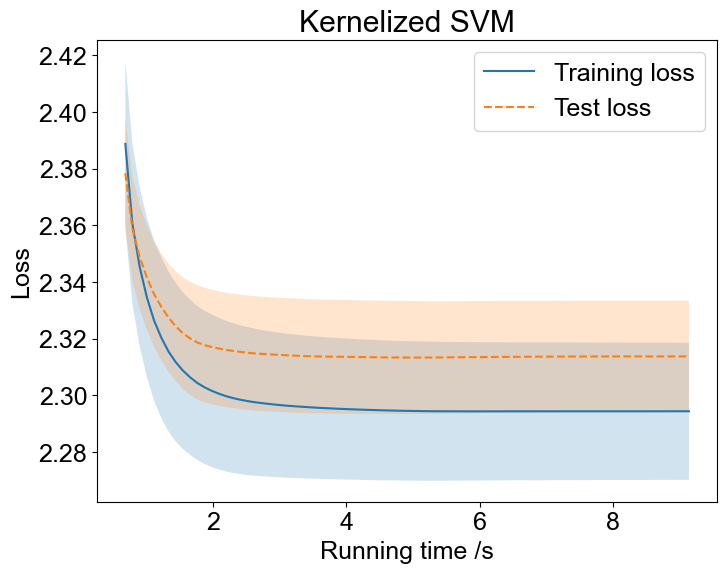

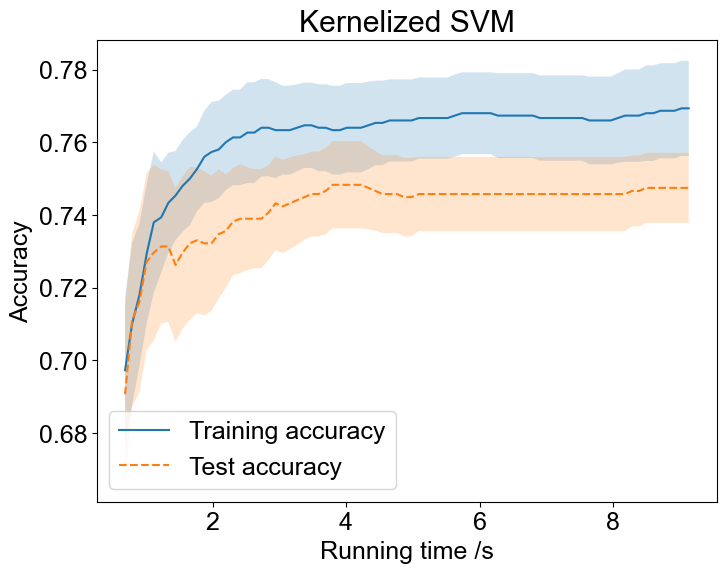

In [237]:
if __name__ == "__main__":
    val_loss_array=[]
    test_loss_array=[]
    val_acc_array=[]
    test_acc_array=[]
    for seed in range(10):
        val_loss_list,test_loss_list,val_acc_list,test_acc_list,time_computation=run_ours(seed)
        val_loss_array.append(np.array(val_loss_list))
        test_loss_array.append(np.array(test_loss_list))
        val_acc_array.append(np.array(val_acc_list))
        test_acc_array.append(np.array(test_acc_list))
        time_computation=np.array(time_computation)
    val_loss_array=np.array(val_loss_array)
    test_loss_array=np.array(test_loss_array)
    val_acc_array=np.array(val_acc_array)
    test_acc_array=np.array(test_acc_array)

    val_loss_mean=np.sum(val_loss_array,axis=0)/val_loss_array.shape[0]
    val_loss_sd=np.sqrt(np.var(val_loss_array,axis=0))/2.0
    test_loss_mean=np.sum(test_loss_array,axis=0)/test_loss_array.shape[0]
    test_loss_sd=np.sqrt(np.var(test_loss_array,axis=0))/2.0

    val_acc_mean=np.sum(val_acc_array,axis=0)/val_acc_array.shape[0]
    val_acc_sd=np.sqrt(np.var(val_acc_array,axis=0))/2.0
    test_acc_mean=np.sum(test_acc_array,axis=0)/test_acc_array.shape[0]
    test_acc_sd=np.sqrt(np.var(test_acc_array,axis=0))/2.0

    plt.rcParams.update({'font.size': 18})
    plt.rcParams['font.sans-serif']=['Arial']#如果要显示中文字体，则在此处设为：SimHei
    plt.rcParams['axes.unicode_minus']=False #显示负号
    axis=time_computation
    plt.figure(figsize=(8,6))
    #plt.grid(linestyle = "--") #设置背景网格线为虚线
    ax = plt.gca()
    plt.plot(axis,val_loss_mean,'-',label="Training loss")
    ax.fill_between(axis,val_loss_mean-val_loss_sd,val_loss_mean+val_loss_sd,alpha=0.2)
    plt.plot(axis,test_loss_mean,'--',label="Test loss")
    ax.fill_between(axis,test_loss_mean-test_loss_sd,test_loss_mean+test_loss_sd,alpha=0.2)
    #plt.xticks(np.arange(0,iterations,40))
    plt.title('Kernelized SVM')
    plt.xlabel('Running time /s')
    #plt.legend(loc=4)
    plt.ylabel("Loss")
    #plt.xlim(-0.5,3.5)
    #plt.ylim(0.5,1.0)
    plt.legend(loc=0, numpoints=1)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    #plt.setp(ltext, fontsize=18,fontweight='bold') #设置图例字体的大小和粗细
    plt.savefig('ho_svm_kernel_1.pdf') 
    #plt.show()

    axis=time_computation
    plt.figure(figsize=(8,6))
    ax = plt.gca()
    plt.plot(axis,val_acc_mean,'-',label="Training accuracy")
    ax.fill_between(axis,val_acc_mean-val_acc_sd,val_acc_mean+val_acc_sd,alpha=0.2)
    plt.plot(axis,test_acc_mean,'--',label="Test accuracy")
    ax.fill_between(axis,test_acc_mean-test_acc_sd,test_acc_mean+test_acc_sd,alpha=0.2) 
    #plt.xticks(np.arange(0,iterations,40))
    plt.title('Kernelized SVM')
    plt.xlabel('Running time /s')
    plt.ylabel("Accuracy")
    # plt.ylim(0.64,0.8)
    #plt.legend(loc=4)
    plt.legend(loc=0, numpoints=1)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    #plt.setp(ltext, fontsize=18,fontweight='bold') #设置图例字体的大小和粗细
    plt.savefig('ho_svm_kernel_2.pdf') 
    plt.show()